<a href="https://colab.research.google.com/github/seblutzer/da-ebac/blob/main/An%C3%A1lise%20Explorat%C3%B3rio%20de%20Dados%20para%20Loggi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Análise de Dados: Análise Exploratória de Dados de Logística II
Caderno de **Exercícios**<br>
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)

---

# **Tópicos**

<ol type="1">
  <li>Manipulação;</li>
  <li>Visualização;</li>
  <li>Storytelling.</li>
</ol>


---

# **Exercícios**

Este *notebook* deve servir como um guia para **você continuar** a construção da sua própria análise exploratória de dados. Fique a vontate para copiar os códigos da aula mas busque explorar os dados ao máximo. Por fim, publique seu *notebook* no [Kaggle](https://www.kaggle.com/).

---

# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

Este projeto foi desenvolvido para a empresa Loggi, uma das principais empresas de logística do Brasil. O objetivo do projeto foi analisar dados de entregas realizadas pela empresa na região do Distrito Federal, a fim de identificar padrões e tendências que possam ser úteis na otimização do processo logístico. Para isso, foram utilizadas técnicas de visualização de dados, como mapas de calor e gráficos de barras, que permitem uma análise mais clara e objetiva dos dados.

Os gráficos e mapas de calor desenvolvidos neste projeto serão importantes para a análise de dados da empresa, pois permitem uma visualização mais intuitiva e fácil de entender dos dados, facilitando a identificação de padrões e tendências. Com isso, a empresa poderá tomar decisões mais acuradas em relação ao processo de entregas, o que poderá resultar em uma maior eficiência e redução de custos operacionais.

## 2\. Pacotes e bibliotecas

In [ ]:
!pip3 install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import json
import os
import math

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopy
import numpy as np

import geopandas
import folium
from folium.plugins import HeatMap
from geopy import distance
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

## 3\. Exploração de dados

In [ ]:
# faça o código de exploração de dados:
#
# - coleta de dados;
# - wrangling da estrutura;
# - exploração do schema;
# - etc.

In [ ]:
# Fonte
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json

# Coleta de dados
with open('deliveries.json', mode='r', encoding='utf8') as file:
  data = json.load(file)

In [ ]:
# Criação do DataFrame base
deliveries_df = pd.DataFrame(data)

# Divisão de 'origin' em 'lng' e 'lat'
hub_origin_df = pd.json_normalize(deliveries_df["origin"])

# Fusão dos dois DataFrames
deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)

# Exclusão da coluna 'origin' e organização do DataFrame:
deliveries_df = deliveries_df.drop("origin", axis=1)
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]]

# Renomear as colunas 'lat' e 'lng' para identificá-las como pertencendo ao hub
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)
deliveries_df.head()

# Criar um dataframe para os dados da coluna 'deliveries' mantendo o índice
deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")

# Criar mais um DataFrame com os campos 'size', 'lat' e 'lng'
deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)

# Excluir a coluna 'deliveries' do dataframe inicial
deliveries_df = deliveries_df.drop("deliveries", axis=1)

# Mesclar ambos dataframes com base na quantidade de entregas
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)

deliveries_df

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055
...,...,...,...,...,...,...,...,...
636144,cvrp-2-df-62,df-2,-48.054989,-15.838145,180,8,-48.064269,-15.997694
636145,cvrp-2-df-62,df-2,-48.054989,-15.838145,180,4,-48.065176,-16.003597
636146,cvrp-2-df-62,df-2,-48.054989,-15.838145,180,9,-48.065841,-16.003808
636147,cvrp-2-df-62,df-2,-48.054989,-15.838145,180,1,-48.062327,-16.001568


In [ ]:
# Capitação do Mapa
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

#Formação do Mapa
mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]
mapa.head()

replace ./maps/ASB_Cemiterio_A.dbf? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."


In [ ]:
# Geração de um dataframe padrão para parâmetros gerais do Hub
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))

#Adição do Endereço do Hub
geolocator = Nominatim(user_agent="ebac_geocoder")
location = geolocator.reverse("-15.657013854445248, -47.802664728268745")

geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)
geo_hub_df["coordinates"] = geo_hub_df["hub_lat"].astype(str)  + ", " + geo_hub_df["hub_lng"].astype(str)
geo_hub_df["geodata"] = geo_hub_df["coordinates"].apply(geocoder)

geo_hub_df.head()

,region,hub_lng,hub_lat,geometry,coordinates,geodata
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814),"-15.83814451122274, -48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512),"-15.80511751066334, -47.89366206897872","(Bloco B / F, SQS 303, SQS 103, Asa Sul, Brasí..."
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701),"-15.657013854445248, -47.802664728268745","(Clinica dos Olhos, Rua 7, Quadra 2, Sobradinh..."


In [ ]:
# Extração de dados geopolíticos dos Hubs
hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))

hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)

# Criação de Dataframe para indicar Bairro e Cidade dos Hubs
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]

#Adição de Bairro e Cidade de cada Hub em cada entrega
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]

In [ ]:
# Carregamento de dados geopolíticos dos pontos de entrega
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv

# Adição do POINT para cada ponto de entrega
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))

# Dataframe com dados geopolíticos
deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")

#Agregação de dados geopolíticos ao dataframe padrão
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)

# Preencher os espaços vazios com informações genéricas
deliveries_df['delivery_city'] = deliveries_df['delivery_city'].fillna('Distrito Federal')
deliveries_df['delivery_suburb'] = deliveries_df['delivery_suburb'].fillna('Zona Rural')

deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,geometry,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,POINT (-48.11619 -15.84893),Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,POINT (-48.11819 -15.85077),Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,POINT (-48.11248 -15.84787),Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,POINT (-48.11802 -15.84647),Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,POINT (-48.11490 -15.85805),Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


## 4\. Manipulação

In [ ]:
# faça o código de manipulação de dados:
#
# - enriquecimento;
# - controle de qualidade;
# - etc.

In [ ]:
# cria uma função para calcular a distância em metros entre dois pontos
def calculate_distance(row):
    delivery_point = (row["delivery_lat"], row["delivery_lng"])
    hub_point = (row["hub_lat"], row["hub_lng"])
    return geodesic(delivery_point, hub_point).kilometers

# adiciona uma coluna com a distância em metros até o hub correspondente
deliveries_df["distance_to_hub"] = deliveries_df.apply(lambda row: calculate_distance(row), axis=1)

In [ ]:
deliveries_df.describe()

,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,distance_to_hub
count,636149.000000,636149.000000,636149.0,636149.000000,636149.000000,636149.000000,636149.000000
mean,-47.949902,-15.802359,180.0,5.512111,-47.946087,-15.809492,7.081822
std,0.091875,0.053463,0.0,2.874557,0.112769,0.082462,5.327246
min,-48.054989,-15.838145,180.0,1.000000,-48.280779,-16.050028,0.003377
25%,-48.054989,-15.838145,180.0,3.000000,-48.035911,-15.842795,3.672008
50%,-47.893662,-15.805118,180.0,6.000000,-47.928967,-15.814033,5.517670
75%,-47.893662,-15.805118,180.0,8.000000,-47.883394,-15.769516,8.875794
max,-47.802665,-15.657014,180.0,10.000000,-47.310611,-15.500355,67.847814


In [ ]:
# definir os limites dos intervalos de 0,5 km
bins = pd.interval_range(start=0, end=70, freq=0.5)

# agrupar por região e por intervalo de 0,5 km
grouped = deliveries_df.groupby(['region', pd.cut(deliveries_df['distance_to_hub'], bins)])

# contar a quantidade total de entregas em cada intervalo
distr_df = grouped['delivery_size'].sum().reset_index()

# renomear a coluna de contagem para indicar a quantidade total de entregas
distr_df = distr_df.rename(columns={'delivery_size': 'total_delivery_size'})

# criar coluna 'delivery_size' e 'resto'
distr_df['delivery_size'] = distr_df['total_delivery_size']
distr_df['resto'] = 0

# criar a coluna 'soma_total_delivery_size'
distr_df['soma_total_delivery_size'] = 0

# percorrer as linhas agrupadas por região
for region, group in distr_df.groupby('region'):
    group_idx = group.index

    # percorrer as linhas do grupo
    for idx in group_idx:
        # calcular a soma do 'total_delivery_size' das linhas abaixo da linha atual e pertencentes ao mesmo region
        soma_total = group.loc[idx:, 'total_delivery_size'].sum()

        # atribuir a soma calculada na coluna 'soma_total_delivery_size'
        distr_df.loc[idx, 'soma_total_delivery_size'] = soma_total



# percorrer as linhas agrupadas por região
for region, group in distr_df.groupby('region'):
    group_idx = group.index

    # primeira linha
    first_idx = group_idx[0]
    if distr_df.loc[first_idx, 'total_delivery_size'] > 0:
        delivery_size = np.floor_divide(distr_df.loc[first_idx, 'total_delivery_size'], 180) * 180
        distr_df.loc[first_idx, 'delivery_size'] = delivery_size
        distr_df.loc[first_idx, 'resto'] = distr_df.loc[first_idx, 'total_delivery_size'] - delivery_size

    # linhas seguintes
    for idx in group_idx[1:]:
        if distr_df.loc[idx, 'soma_total_delivery_size'] == distr_df.loc[idx, 'delivery_size'] and distr_df.loc[idx, 'soma_total_delivery_size'] > 0:
            distr_df.loc[idx, 'delivery_size'] = distr_df.loc[idx-1, 'valor_parcial']
            distr_df.loc[idx, 'resto'] = 0
        else:
            distr_df.loc[idx, 'valor_parcial'] = distr_df.loc[idx-1, 'resto'] + distr_df.loc[idx, 'total_delivery_size']
            delivery_size = np.floor_divide(distr_df.loc[idx, 'valor_parcial'], 180) * 180
            distr_df.loc[idx, 'delivery_size'] = delivery_size
            distr_df.loc[idx, 'resto'] = distr_df.loc[idx, 'valor_parcial'] - delivery_size

        # atualizar o valor_parcial
        distr_df.loc[idx, 'valor_parcial'] = distr_df.loc[idx-1, 'resto'] + distr_df.loc[idx, 'total_delivery_size'] if idx != first_idx else distr_df.loc[idx, 'total_delivery_size']

    # atualizar o 'delivery_size' da primeira linha do próximo grupo para levar em conta o 'resto' da última linha do grupo anterior
    next_first_idx = distr_df.index.get_loc(group_idx[-1]) + 1
    if next_first_idx < len(distr_df):
        distr_df.loc[next_first_idx, 'delivery_size'] = distr_df.loc[group_idx[-1], 'resto']
# Adicionar quantidade de viagens e distância percorrida
distr_df['trips'] = distr_df['delivery_size'].apply(lambda x: math.ceil(x / 180))
distr_df['distance_to_hub'] = distr_df['distance_to_hub'].apply(lambda x: x.right).astype('float64')
distr_df['distance'] = distr_df['trips'] * distr_df['distance_to_hub']

# Limpar colunas temporárias
distr_df.drop(['delivery_size', 'resto', 'soma_total_delivery_size', 'valor_parcial'], axis=1, inplace=True)

distr_df.head()

,region,distance_to_hub,total_delivery_size,trips,distance
0,df-0,0.5,10023,55,27.5
1,df-0,1.0,15010,84,84.0
2,df-0,1.5,15653,87,130.5
3,df-0,2.0,12814,71,142.0
4,df-0,2.5,13627,75,187.5


In [ ]:
region_df = distr_df.groupby('region').agg({'total_delivery_size': 'sum', 'trips': 'sum', 'distance': sum})

# Mesclar dataframes
geo_hub_df = geo_hub_df.merge(region_df, on='region')

# Adicionar distância média
geo_hub_df['mean_distance'] = geo_hub_df['distance'] / geo_hub_df['trips']

# Calcular percentuais da distância total e da distância média
total_distance = geo_hub_df["distance"].sum()
mean_distance = geo_hub_df["mean_distance"].sum()
geo_hub_df["distance_perc"] = (geo_hub_df["distance"] / total_distance) * 100
geo_hub_df["mean_distance_perc"] = (geo_hub_df["mean_distance"] / mean_distance) * 100

geo_hub_df

## 5\. Visualização

<ipython-input-15-fe8b2abb2a5b>:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:


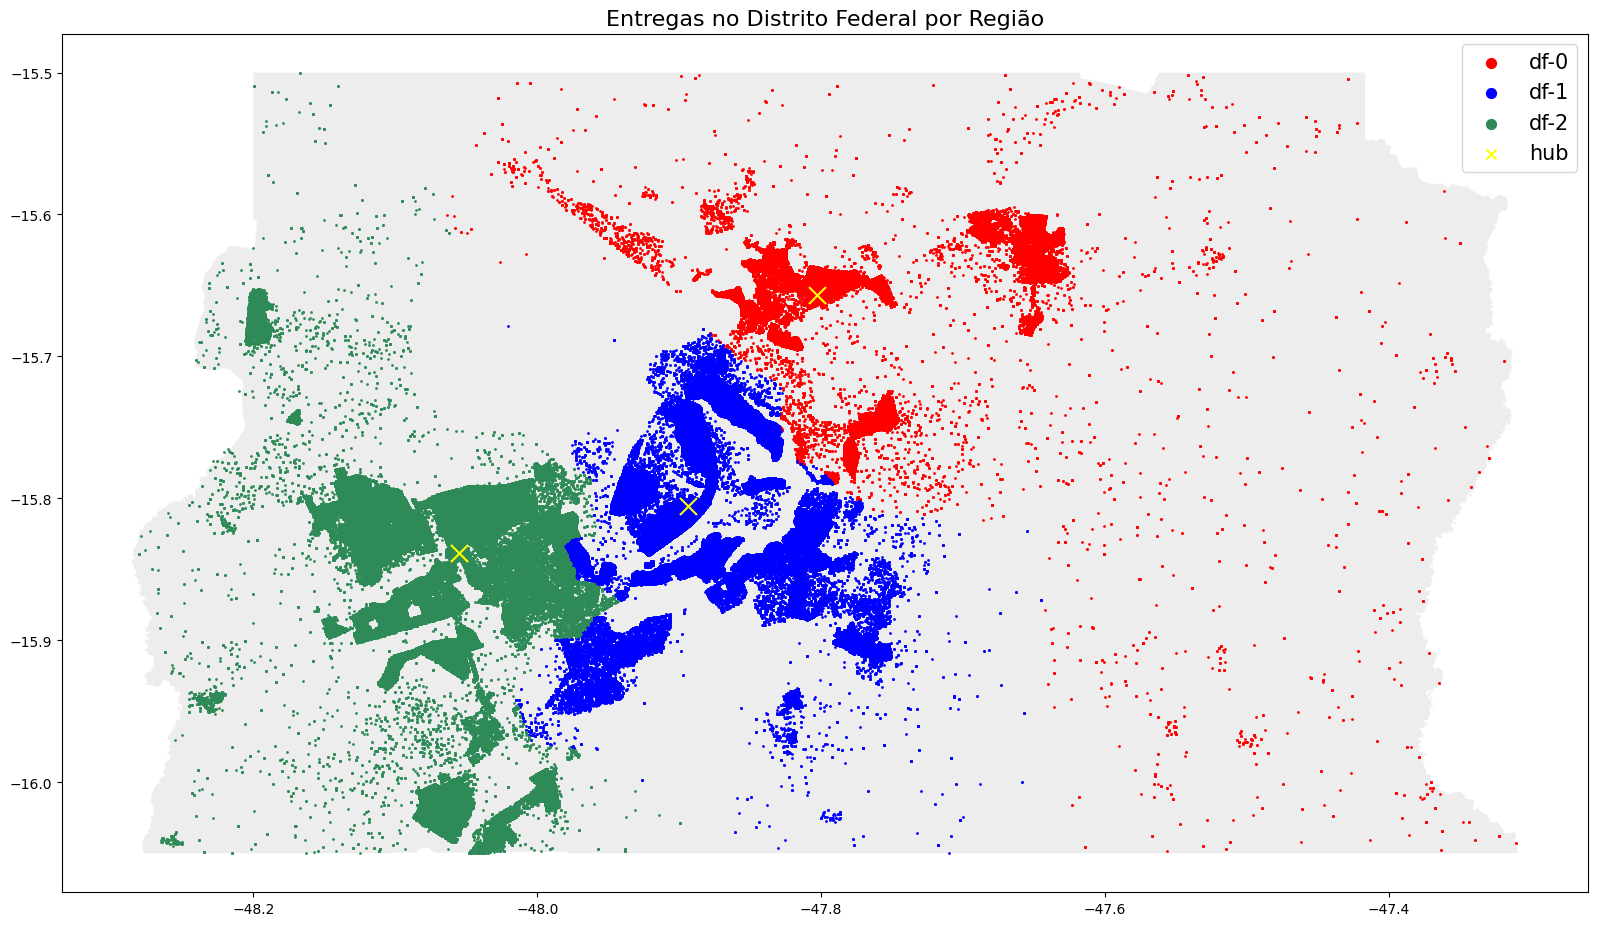

In [ ]:
# cria o plot vazio
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="red", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=150, marker="x", color="yellow", label="hub")

# plot da legenda
plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([50])

* Podemos ver que a área de abrangência da região 0 é bem maios que as outras regiões, especialmente a região 1.
* A Região 1 está bem mais concentrada que as demais regiões, e aparenta ter mais pedidos também.
* Os Hubs se localizam nas regiões de maiores pedidos, não nas regiões mais centralizadas dentro do campo de entrega.

Text(0, 0.5, 'Região')

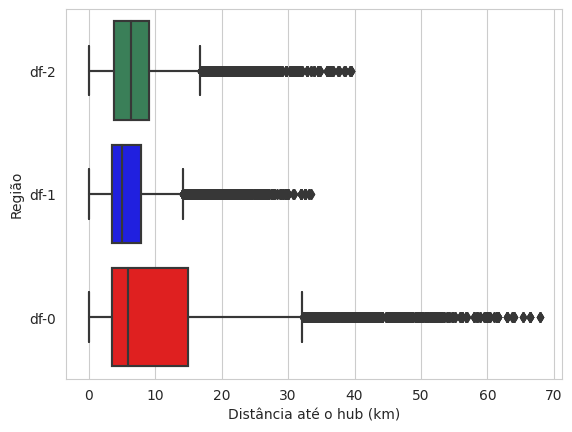

In [ ]:
# Boxplot das distâncias para cada região
sns.set_style("whitegrid")
box_region = sns.boxplot(x='distance_to_hub', y='region', data=deliveries_df)
# Define as cores para cada região
colors = {"df-0": "red", "df-1": "blue", "df-2": "seagreen"}
# Plot do boxplot com a paleta de cores definida
box_region = sns.boxplot(x='distance_to_hub', y='region', data=deliveries_df, palette=colors)
# Renomear os eixos
box_region.set_xlabel("Distância até o hub (km)")
box_region.set_ylabel("Região")

* É perceptível que a região 0 tem tragetos muito maiores a ser percorrido em suas entregas, com a maior parte de suas entregas entre 5 e 15 km, mas com muitas entregas até um raio de 32km, com extenção máxima de 68km de raio.
* A região 1 e 2 estão bem distribuídas no quesito espaço, porém a região 1 é mais concentrada que a 2.

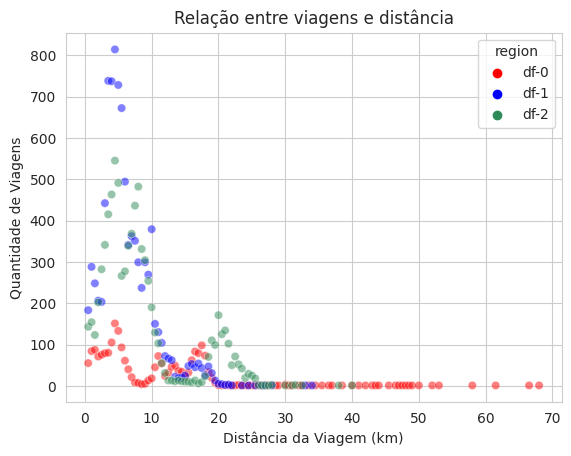

In [ ]:
sns.set_style('whitegrid')
sns.scatterplot(data=distr_df[distr_df['trips'] > 0], x='distance_to_hub', y='trips', hue='region', palette=["red", "blue", "seagreen"], alpha=0.5)
plt.xlabel('Distância da Viagem (km)')
plt.ylabel('Quantidade de Viagens')
plt.title('Relação entre viagens e distância')
plt.show()

* Aqui é possível ver a distribuição de viagens para entregar todos os pedidos.
* A grande maioria das viagens da região 1 está por volta de 5km de raio.
* A região 2 também apresenta muitas viagens entre 5km e 10km de raio, entre 12 e 18km são poucas viagens e entre 18 e 25km aparece mais um pico com muitas viagens.
* As viagens para a região 0 são mais distribuídas até 20km de raio, e após isso, são poucas as que vão até 68km.

In [ ]:
# Criar um mapa centrado no Brasil
mapa = folium.Map(location=[-15.788497,-47.879873], zoom_start=10)

# Criar um mapa de calor com base nas entregas por região
heat_data = deliveries_df[['delivery_lat', 'delivery_lng', 'delivery_size']].values.tolist()
max_val = deliveries_df['delivery_size'].max() * 10 # Aumentar o max_val
HeatMap(heat_data, max_val=max_val, radius=20).add_to(mapa) # Aumentar o radius
# Mostrar o mapa
mapa


In [ ]:
* Essa é a concentração de pacotes a serem entregues por toda a região.

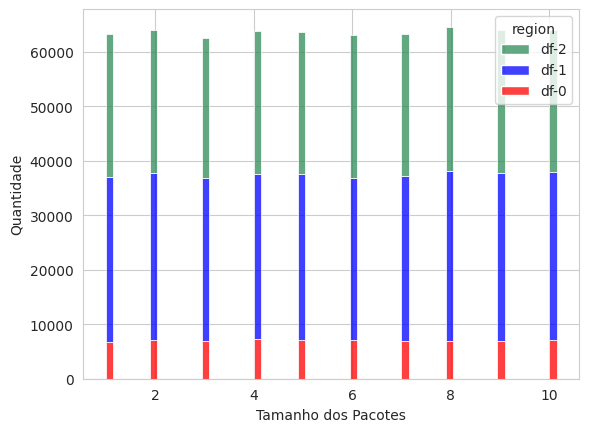

In [ ]:
sns.histplot(data=deliveries_df, x="delivery_size", hue="region", palette=["seagreen", "blue", "red"], multiple="stack", binwidth=0.15)
plt.xlabel("Tamanho dos Pacotes")
plt.ylabel("Quantidade")
plt.show()

* Não existe uma predominância em relação a volume por pedido com relação a nenhuma região e nenhum volume.

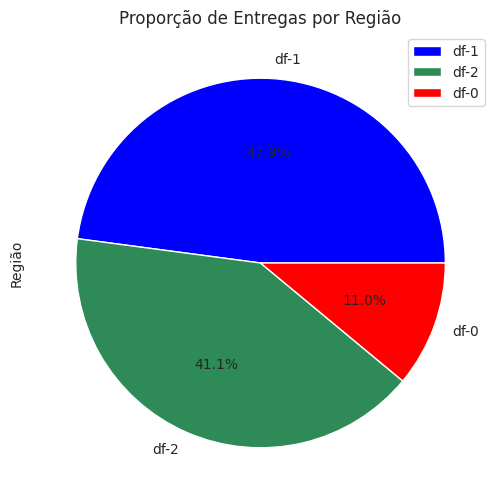

In [ ]:
# Criar um novo dataframe com o número de entregas por região
deliveries_by_region = deliveries_df.groupby('region').agg({'name': 'count'})

# Ordenar as regiões por número total de entregas
deliveries_by_region = deliveries_by_region.sort_values(by='name', ascending=False)

# Criar gráfico de pizza
colors_pie = ["blue", "seagreen", "red"]
deliveries_by_region.plot(kind='pie', y='name', figsize=(6,6), autopct='%1.1f%%', colors=colors_pie)

# Configurar o gráfico
plt.title("Proporção de Entregas por Região")
plt.ylabel("Região")
plt.show()

* A quantidade de entregas na região 1 somam quase 50% de todas as entregas.
* A grande distância que deve ser percorrida na região 0 torna a região com poucas entregas.

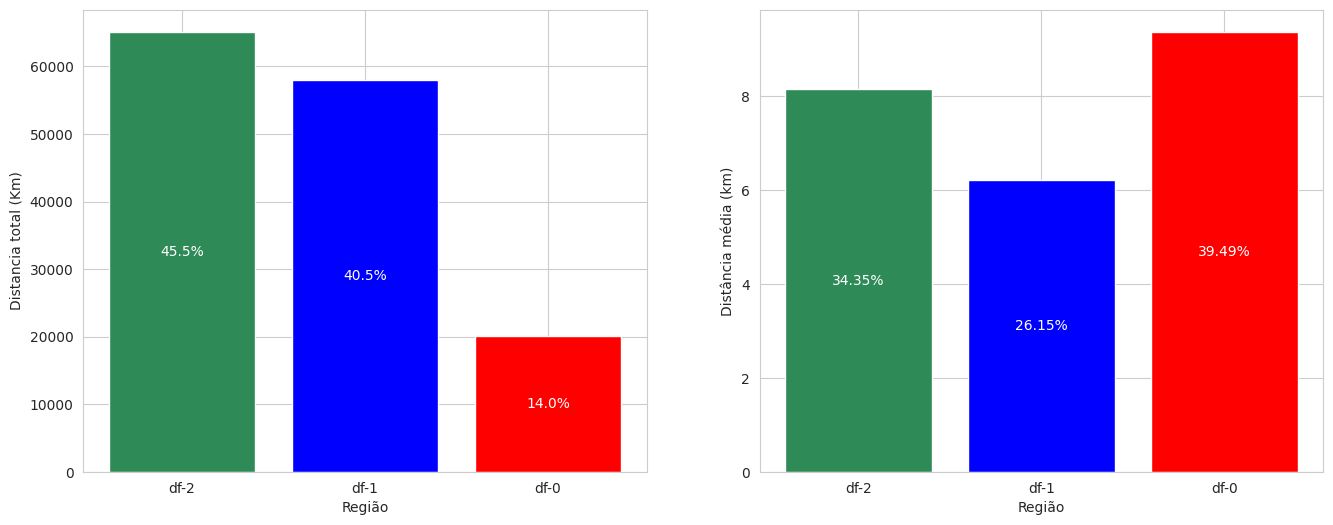

In [ ]:
# cria o gráfico de barras para a coluna "Total distance"
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))
bars1 = ax1.bar(geo_hub_df["region"], geo_hub_df["distance"], label="Distancia Total", color=['seagreen', 'b', 'r'])
ax1.set_xlabel("Região")
ax1.set_ylabel("Distancia total (Km)")

# adiciona os valores percentuais das barras do gráfico "Distancia Total"
labels = [f"{v:.1f}%" for v in geo_hub_df["distance_perc"]]
plt.bar_label(bars1, labels=labels, label_type="center", color='white')

# cria o gráfico de barras para a coluna "Mean distance"
bars2 = ax2.bar(geo_hub_df["region"], geo_hub_df["mean_distance"], label="Distancia Média", color=['seagreen', 'b', 'r'])
ax2.set_xlabel("Região")
ax2.set_ylabel("Distância média (km)")

# adiciona os valores percentuais das barras do gráfico "Distancia Média"
labels = [f"{v:.2f}%" for v in geo_hub_df["mean_distance_perc"]]
plt.bar_label(bars2, labels=labels, label_type="center", color='white')

plt.show()


* Esse gráfico compara a distância total que deve ser percorrido por cada região e a distância média de cada viagem.
* A despeito da região 1 ter quase 5x mais viagens para ser feita do que a região 0, a distância percorrida pela região 1 é apenas 3x maior que pela região 0, pois a distância média por viagem da região 0 é 1,5x maior que da região 1.